In [1]:
import scipy.sparse as sp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse.linalg
import time

##  Первое задание. Предобусловленный метод сопряженных градиентов.

Задача, решить линейную систему:
$$
Ax = b
$$

Где $A$ -  матрица оператора Лапласа, $b$ константный вектор.



$$
\begin{equation}
A =  \frac{1}{h^2}
\begin{pmatrix}
2 & -1 & \cdots & 0 &0 \\
-1 & 2 & \cdots & 0 & 0\\
\vdots  & \vdots  & \ddots & \vdots & \vdots \\
0 & 0& \cdots &-2 & 1 \\
0 & 0& \cdots &-1 & 1
\end{pmatrix}
\label{eq::Amat}
\end{equation}
$$

$h$ - Шаг сетки. Пусть сетка равномерная, тогда $h=\frac{1}{n+1}$, где $n+1$ - количество узлов в сетке. 


Задать такую матрицу и вектор можно следкющим образом 

In [56]:
#n можно взять любым больше 100. Перевести разрженную матрицу в плотную можно мотодом toarray()
np.random.seed(23)

n = 1000
A =  sp.diags([-1, 2, -1], [-1,0,1], shape = (n, n)) 
A =  A *(n+1)**2

#константный вектор правой части
b =  np.ones(n) * 6.

# рандомная начальная точка
x0 = np.random.rand(n)


Число обусловленности такой матрицы будет большим

In [57]:
w, _= np.linalg.eig(A.toarray())
np.linalg.cond(A.toarray()), max(w)/min(w)

(406095.0426485843, 406095.04267807666)

In [58]:
np.isclose(max(w)/min(w), np.linalg.cond(A.toarray()))

True

In [59]:
A

<1000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 2998 stored elements (3 diagonals) in DIAgonal format>

Проверить, как отработает метод сопряженных градиентов на такой задаче. (Метод можно взять из семинара)

Написать метод сопряженных градиентов, учитывая действие предобуславлевателя. 


![](PCG.png)

([Полный текст тут](http://www.cse.psu.edu/~b58/cse456/lecture20.pdf))

Написать метод сопряженных градиентов, учитывая действие предобуславлевателя. 

In [60]:
def PreconditionedCG(x0, A, b, tol=1e-8, M_inv = None):
    r0 = b - A @ x0
    cond = not (M_inv is None)
    if cond:
        z0 = M_inv @ r0
    else:
        z0 = r0
    
    p1 = z0
    w = A @ p1
    alpha1 = (r0.T @ z0) / (p1.T @ w)
    x1 = x0 + alpha1 * p1
    r1 = r0 - alpha1 * w
    k = 1
    
    while np.linalg.norm(r1) > tol :
        if cond:
            z1 = M_inv @ r1
        else:
            z1 = r1
        beta = (r1.T @ z1) / (r0.T @ z0)
        p2 = z1 + beta * p1
        w = A @ p2
        alpha2 = (r1.T @ z1) / (p2.T @ w) 
        x2 = x1 + alpha2 * p2
        r2 = r1 - alpha2 * w
        k += 1
        
        r0 = np.copy(r1)
        
        z0 = np.copy(z1)
        
        r1 = np.copy(r2)
        p1 = np.copy(p2)
        x1 = np.copy(x2)
    return x1, k

Проверить работу метода на предобуславлевателе Гаусса-Зейделя. Обратите внимание, что есть симметричный и не симметричные варианты. Какой надо взять?([Статья с предобуславлевателями для метода сопряжённых градиентов](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.592.1575&rep=rep1&type=pdf))

In [61]:
def SGS_preconditioner(A):
    A = np.asarray(A)
    D = np.diag(np.diag(A))
    L = np.tril(A)
    U = np.triu(A)
    SGS = (D + L) @ np.linalg.inv(D) @ (D + U)
    return SGS

In [62]:
A1 = A.toarray()

In [63]:
M_inv = np.linalg.inv(SGS_preconditioner(A1))
start_time = time.time()
ans, steps = PreconditionedCG(x0, A1, b, M_inv = M_inv)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.421875 seconds ---


In [64]:
steps

642

In [66]:
start_time = time.time()
ans2, steps2 = PreconditionedCG(x0, A1, b)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.2603130340576172 seconds ---


In [67]:
steps2

1001

Сравните результат работы предобусловленной и непредобусловленной версии

Видно, что обусловленный метод делает на ~36% меньше шагов, но работает чуть дольше.

## Второе задание. Метод момента

Реализовать Метод момента.

![](Momentum.png)

([Картинка отсюда](https://cs231n.github.io/neural-networks-3/))

Сравнить его с методом Нестерова и методом градиентного спуска, которые были преддставлены на семинаре. Сравнивать можно на $2D$  задаче с семинара

In [76]:
import types
def backtracking (x, f, grad_f, rho, alpha0, beta1, beta2):
    
    alpha = alpha0
    if isinstance(grad_f ,types.FunctionType):
        phi1 = f(x) -  beta1 * alpha * grad_f(x).dot(grad_f(x))
        phi2 = f(x) -  beta2 * alpha * grad_f(x).dot(grad_f(x))    
        f_k = f(x - alpha * grad_f(x)) 
    else:
        phi1 = f(x) -  beta1 * alpha * grad_f @ grad_f
        phi2 = f(x) -  beta2 * alpha * grad_f @ grad_f  
        f_k = f(x - alpha * grad_f) 

    while not ((f_k <=phi1) and 
              (f_k >=phi2)):
        alpha *= rho
        
        if isinstance(grad_f ,types.FunctionType):
            phi1 = f(x) -  beta1 * alpha * grad_f(x).dot(grad_f(x))
            phi2 = f(x) -  beta2 * alpha * grad_f(x).dot(grad_f(x))    
            f_k = f(x - alpha * grad_f(x)) 
        else: 
            phi1 = f(x) -  beta1 * alpha * grad_f @ grad_f
            phi2 = f(x) -  beta2 * alpha * grad_f @ grad_f  
            f_k = f(x - alpha * grad_f) 
        if alpha < 1e-17:

            return alpha / rho

    return alpha

def  get_x_y_from_callback(array, x0):
    x_array = [x0[0]]
    y_array = [x0[0]]
    for el in array:
        x_array.append(el[0])
        y_array.append(el[1])
        
    return np.array(x_array), np.array(y_array)

In [77]:
sns.set()
np.random.seed(23)
n=100
# строим и нормализуем матрицу
A = np.array([[4,3], [3,4]])
U = np.random.rand(2, 2)
Q, _ = np.linalg.qr(U)
A = Q.dot(A).dot(Q.T)
A = (A + A.T) * 0.5

n_points = 100

u = np.linspace(-4, 4, n_points)
x, y = np.meshgrid(u, u)
b = np.random.rand(2)
X = np.vstack([x.flatten(), y.flatten()])

# строим изолинии
f_x = X.T @ A @ X - b @ X

f_x = np.diag(f_x).reshape(n_points, n_points)


# b I used  in my own experiments array([0.22104536, 0.68622209]) 

# начальное приближение
x0 = np.array([-4. , -4.])


# вспомогательные функции для кастомного Gradient DEscent
f = lambda x: 0.5 * x.dot(A.dot(x)) - b.dot(x)
grad_f = lambda x: A.dot(x) - b

In [78]:
def NesterovAcceleratedGD(f, gradf, x0, momentum =0.9, max_iter=1000, tol=1e-8,  rho=0.5, beta1=0.2):
    x = x0.copy()
    iteration = 0
    conv_array = []

    change = np.zeros(x.shape)
   
    while True:

        beta2 = 1. -beta1
        #TO DO
        proj = x + momentum * change
        
        gradient = gradf(proj)
        alpha = backtracking (x, f, gradf, rho=rho, alpha0=1., beta1=beta1, beta2=beta2)
        change = momentum * change - alpha * gradient
        x = x  + change
        
        #END TO DO
        iteration += 1
        if np.linalg.norm(gradf(x)) < tol:
            break
        if iteration >= max_iter:
            break
        conv_array.append(x)
    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradf(x)),  "conv_array": conv_array}
    return res

In [79]:
def AcceleratedGD(f, gradf, x0, momentum =0.9, max_iter=1000, tol=1e-8,  rho=0.5, beta1=0.2):
    x = x0.copy()
    iteration = 0
    conv_array = []

    change = np.zeros(x.shape)
   
    while True:

        beta2 = 1. -beta1
        #TO DO
        gradient = gradf(x)
        alpha = backtracking (x, f, gradf, rho=rho, alpha0=1., beta1=beta1, beta2=beta2)
        change = momentum * change - alpha * gradient
        x = x  + change
        
        #END TO DO
        iteration += 1
        if np.linalg.norm(gradf(x)) < tol:
            break
        if iteration >= max_iter:
            break
        conv_array.append(x)
    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradf(x)),  "conv_array": conv_array}
    return res

In [95]:
def GradientDescent(f, gradf, x0, max_iter=1000, tol=1e-8,  rho=0.7, beta1=0.3):
    x = x0.copy()
    iteration = 0
    conv_array = []

  
    while True:

        beta2 = 1. -beta1
        #TO DO
        alpha = backtracking (x, f, gradf, rho=rho, alpha0=1., beta1=beta1, beta2=beta2)
        gradient = gradf(x)
        x = x - alpha * gradient
        #END TO DO
        iteration += 1
        if np.linalg.norm(gradf(x)) < tol:
            break
        if iteration >= max_iter:
            break
        conv_array.append(x)
    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradf(x)),  "conv_array": conv_array}
    return res

In [126]:
res_nest = NesterovAcceleratedGD(f, grad_f, x0, momentum=0.15)
x_na, y_na = get_x_y_from_callback(res_nest["conv_array"], x0)

res_mom = AcceleratedGD(f, grad_f, x0, momentum=0.2)
x_ma, y_ma = get_x_y_from_callback(res_mom["conv_array"], x0)

res = GradientDescent(f, grad_f, x0, rho=0.5, beta1=0.2)
x_gd, y_gd = get_x_y_from_callback(res['conv_array'], x0)

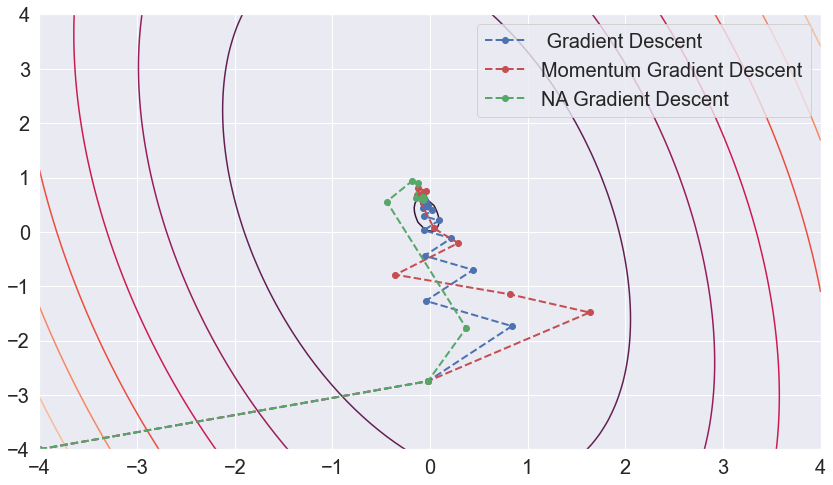

In [127]:
plt.figure(figsize = (14, 8))
plt.plot(x_gd, y_gd, '--bo',linewidth=2, label=' Gradient Descent')
plt.plot(x_ma, y_ma ,'--ro', linewidth=2, label='Momentum Gradient Descent')
plt.plot(x_na, y_na ,'--go', linewidth=2, label='NA Gradient Descent')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(loc="best", fontsize=20)
plt.contour(x, y, f_x)

In [128]:
len(res["conv_array"]), len(res_nest["conv_array"]), len(res_mom["conv_array"])

(69, 30, 38)

Метод Нестерова отличается от простого метода моментов, лишь тем, что в нем мы берем градиент не в самой точке Х, а чуть продвигаясь дальше, действуя как-бы на "опережение".

Эти два метода очень схожи, но метод Нестерова сходится чуть быстрее.